<a href="https://colab.research.google.com/github/putricinto/Machine-Learning-Project---MLCC/blob/master/Exercise1_Bank_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data Preparation**



## Import the Dataset with Pandas
The data set used is **Bank Marketing** from [Kaggle](https://www.kaggle.com/rouseguy/bankbalanced).

In [0]:
%tensorflow_version 2.x

In [0]:
import pandas as pd
import numpy as np
from scipy import stats
import sys
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest, chi2, f_regression
import tensorflow as tf
from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score

In [0]:
url = 'https://raw.githubusercontent.com/putricinto/Machine-Learning-Project---MLCC/master/bank.csv'
bank = pd.read_csv(url)
bank

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,primary,no,1,yes,no,cellular,20,apr,257,1,-1,0,unknown,no
11158,39,services,married,secondary,no,733,no,no,unknown,16,jun,83,4,-1,0,unknown,no
11159,32,technician,single,secondary,no,29,no,no,cellular,19,aug,156,2,-1,0,unknown,no
11160,43,technician,married,secondary,no,0,no,yes,cellular,8,may,9,2,172,5,failure,no


**Informations and Charactheristics of The Data**

In [0]:
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
age          11162 non-null int64
job          11162 non-null object
marital      11162 non-null object
education    11162 non-null object
default      11162 non-null object
balance      11162 non-null int64
housing      11162 non-null object
loan         11162 non-null object
contact      11162 non-null object
day          11162 non-null int64
month        11162 non-null object
duration     11162 non-null int64
campaign     11162 non-null int64
pdays        11162 non-null int64
previous     11162 non-null int64
poutcome     11162 non-null object
deposit      11162 non-null object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB


In [0]:
bank.describe()

,age,balance,day,duration,campaign,pdays,previous
count,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,41.231948,1528.538524,15.658036,371.993818,2.508421,51.330407,0.832557
std,11.913369,3225.413326,8.420740,347.128386,2.722077,108.758282,2.292007
min,18.000000,-6847.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,122.000000,8.000000,138.000000,1.000000,-1.000000,0.000000
50%,39.000000,550.000000,15.000000,255.000000,2.000000,-1.000000,0.000000
75%,49.000000,1708.000000,22.000000,496.000000,3.000000,20.750000,1.000000
max,95.000000,81204.000000,31.000000,3881.000000,63.000000,854.000000,58.000000


**Correlation**

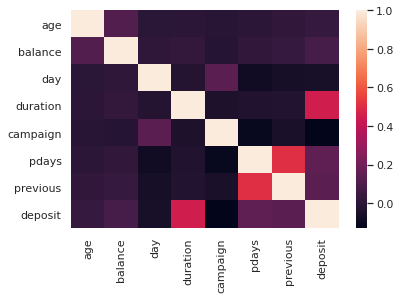

In [0]:
#Correlation Numerical Variables
data=bank.copy()
data['deposit'].replace({'yes':1,'no':0},inplace = True)
sns.heatmap(data.corr(), color='White')

In [0]:
#Correlation Categorical Variables
def cramers_v(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher,
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

In [0]:
#Correlation Categorical Variables with Label
column_name=[]
bankcat=[]
for i in data.columns:
  # for Categorical Features
  if data[i].unique().dtype == np.object:
    confusion_matrix = pd.crosstab(data['deposit'], data[i]).as_matrix()
    bankcat.append(cramers_v(confusion_matrix))
    column_name.append(i)
corr_categoric=pd.DataFrame()
corr_categoric["Variable"]=list(column_name)
corr_categoric["Correlatioan with Label"]=list(bankcat)
corr_categoric

## Data Visualization

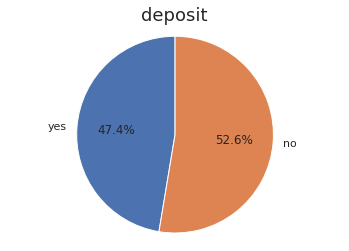

In [0]:
#Pie Chart of The Label (Deposit)
y=list(bank['deposit'])
labels = 'yes', 'no'
sizes = [y.count('yes'), y.count('no')]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title('deposit', fontsize=18)
plt.show()

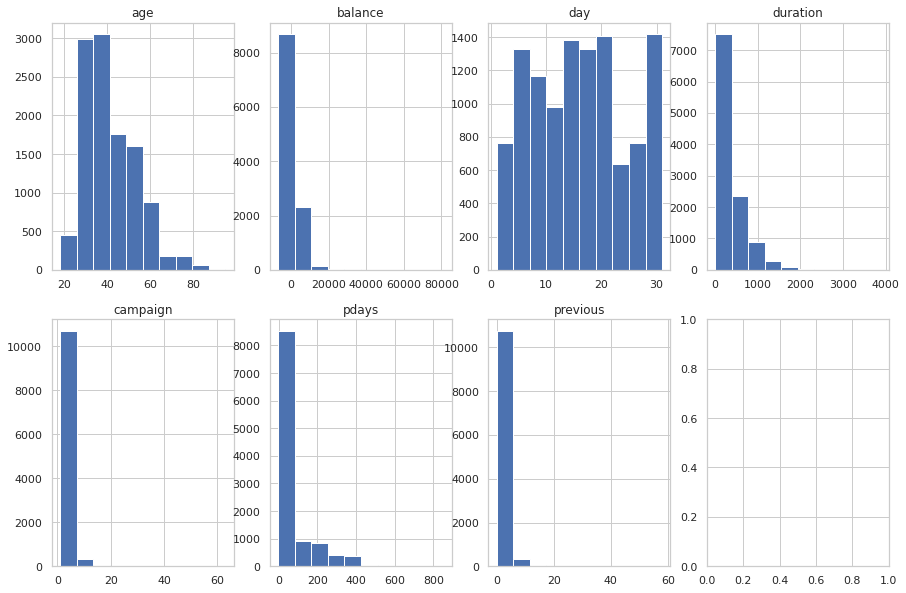

In [0]:
#Histogram of Numerical Variables
fig, axs = plt.subplots(2, 4, figsize=(15, 10))
axs[0, 0].hist(bank['age'])
axs[0, 0].set_title('age')

axs[0, 1].hist(bank['balance'])
axs[0, 1].set_title('balance')

axs[0, 2].hist(bank['day'])
axs[0, 2].set_title('day')

axs[0, 3].hist(bank['duration'])
axs[0, 3].set_title('duration')

axs[1, 0].hist(bank['campaign'])
axs[1, 0].set_title('campaign')

axs[1, 1].hist(bank['pdays'])
axs[1, 1].set_title('pdays')

axs[1, 2].hist(bank['previous'])
axs[1, 2].set_title('previous')

plt.show()

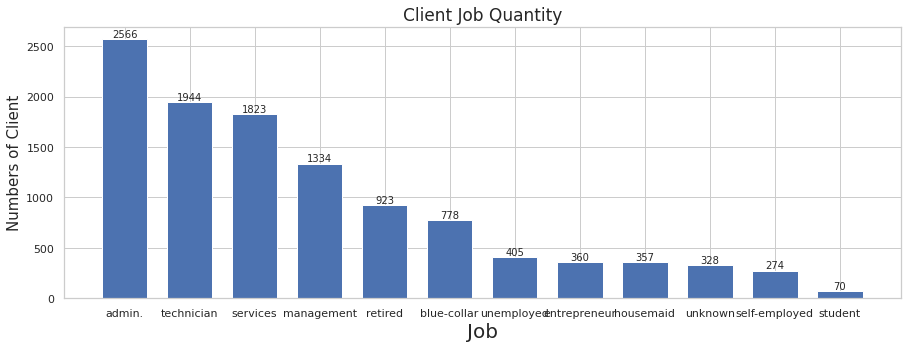

In [0]:
#Job Variable
job = bank['job'].value_counts()
m_height = job.values.tolist() #Provides numerical values
job.axes #Provides row labels
job_labels = job.axes[0].tolist() #Converts index object to list

#=====PLOT Preparations and Plotting====#
ind = np.arange(12)  # the x locations for the groups
width = 0.7        # the width of the bars
fig, ax = plt.subplots(figsize=(15,5))
client_bars = ax.bar(ind, m_height , width)

#Add some text for labels, title and axes ticks
ax.set_xlabel("Job",fontsize=20)
ax.set_ylabel('Numbers of Client',fontsize=15)
ax.set_title('Client Job Quantity',fontsize=17)
ax.set_xticks(ind) #Positioning on the x axis
ax.set_xticklabels(('admin.', 'technician', 'services', 'management', 'retired',
       'blue-collar', 'unemployed', 'entrepreneur', 'housemaid',
       'unknown', 'self-employed', 'student'))

#Auto-labels the number of mushrooms for each bar color.
def autolabel(rects,fontsize=10):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1*height,'%d' % int(height),
                ha='center', va='bottom',fontsize=fontsize)
autolabel(client_bars)        
plt.show() 

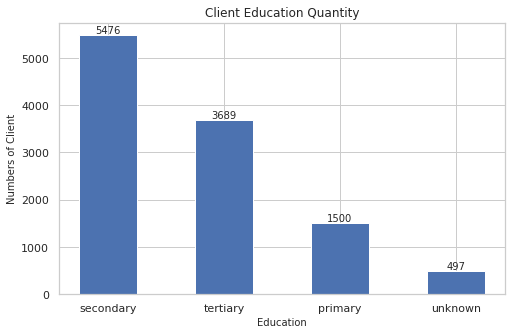

In [0]:
#Education Variable
education = bank['education'].value_counts()
m_height = education.values.tolist() #Provides numerical values
education.axes #Provides row labels
education_labels = education.axes[0].tolist() #Converts index object to list

#=====PLOT Preparations and Plotting====#
ind = np.arange(4)  # the x locations for the groups
width = 0.5        # the width of the bars
fig, ax = plt.subplots(figsize=(8,5))
client_bars = ax.bar(ind, m_height , width)

#Add some text for labels, title and axes ticks
ax.set_xlabel("Education",fontsize=10)
ax.set_ylabel('Numbers of Client',fontsize=10)
ax.set_title('Client Education Quantity',fontsize=12)
ax.set_xticks(ind) #Positioning on the x axis
ax.set_xticklabels(('secondary', 'tertiary', 'primary', 'unknown'))

#Auto-labels the number of mushrooms for each bar color.
def autolabel(rects,fontsize=10):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1*height,'%d' % int(height),
                ha='center', va='bottom',fontsize=fontsize)
autolabel(client_bars)        
plt.show() 

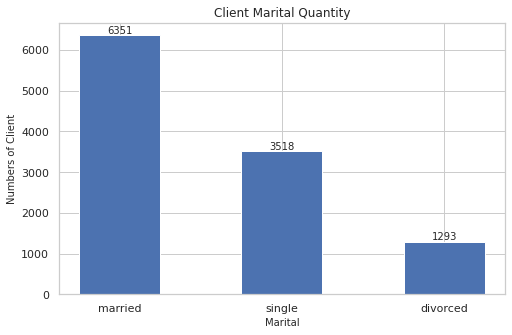

In [0]:
#Marital Variable
marital = bank['marital'].value_counts()
m_height = marital.values.tolist() #Provides numerical values
marital.axes #Provides row labels
marital_labels = marital.axes[0].tolist() #Converts index object to list

#=====PLOT Preparations and Plotting====#
ind = np.arange(3)  # the x locations for the groups
width = 0.5        # the width of the bars
fig, ax = plt.subplots(figsize=(8,5))
client_bars = ax.bar(ind, m_height , width)

#Add some text for labels, title and axes ticks
ax.set_xlabel("Marital",fontsize=10)
ax.set_ylabel('Numbers of Client',fontsize=10)
ax.set_title('Client Marital Quantity',fontsize=12)
ax.set_xticks(ind) #Positioning on the x axis
ax.set_xticklabels(('married', 'single', 'divorced'))

#Auto-labels the number of mushrooms for each bar color.
def autolabel(rects,fontsize=10):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1*height,'%d' % int(height),
                ha='center', va='bottom',fontsize=fontsize)
autolabel(client_bars)        
plt.show() 

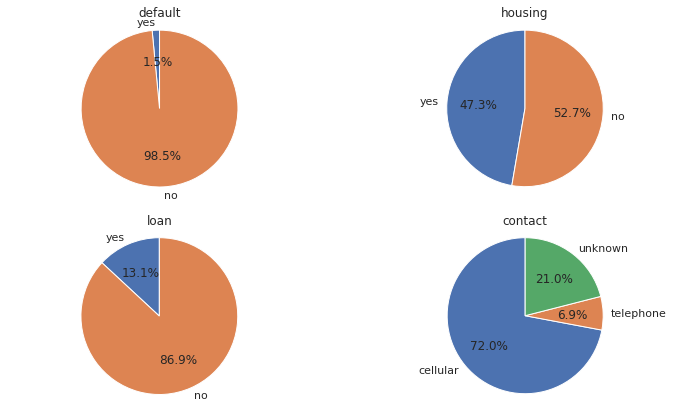

In [0]:
#Pie Chart of The Label (Deposit)
fig, axs = plt.subplots(2, 2, figsize=(12, 7))

y_default=list(bank['default'])
labels_default = 'yes', 'no', 
sizes_default = [y_default.count('yes'), y_default.count('no')]
axs[0,0].pie(sizes_default, labels=labels_default,autopct='%1.1f%%', startangle=90)
axs[0,0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
axs[0,0].set_title('default')

y_housing=list(bank['housing'])
labels_housing = 'yes', 'no'
sizes_housing = [y_housing.count('yes'), y_housing.count('no')]
axs[0,1].pie(sizes_housing, labels=labels_housing,autopct='%1.1f%%', startangle=90)
axs[0,1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
axs[0,1].set_title('housing')

y_loan=list(bank['loan'])
labels_loan = 'yes', 'no'
sizes_loan = [y_loan.count('yes'), y_loan.count('no')]
axs[1,0].pie(sizes_loan, labels=labels_loan,autopct='%1.1f%%', startangle=90)
axs[1,0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
axs[1,0].set_title('loan')

y_contact=list(bank['contact'])
labels_contact = 'cellular', 'telephone','unknown'
sizes_contact = [y_contact.count('cellular'), y_contact.count('telephone'),y_contact.count('unknown')]
axs[1,1].pie(sizes_contact, labels=labels_contact,autopct='%1.1f%%', startangle=90)
axs[1,1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
axs[1,1].set_title('contact')
plt.show()

## **Feature Selection**

In [0]:
df=bank.copy()
df['deposit'].replace({'yes':1,'no':0},inplace = True)
df['education'].replace({'unknown':0,'primary': 1, 'secondary': 2, 'tertiary': 3 },inplace = True)
df['marital'].replace({'single':0,'married': 1, 'divorced': 2,  },inplace = True)
df['default'].replace({'no':0,'yes':1}, inplace=True)
df['housing'].replace({'no':0,'yes':1}, inplace=True)
df['loan'].replace({'no':0,'yes':1}, inplace=True)
df['contact'].replace({'unknown':0,'cellular':1,'telephone':2}, inplace=True)
df['poutcome'].replace({'unknown':0,'failure': 1, 'success': 2, 'other':3},inplace = True)
df['month'].replace({'jan':0,'feb':1,'mar':2,'apr':3,'may':4,'jun':5,'jul':6,'aug':7,'sep':8,'oct':9,'nov':10,'dec':12}, inplace=True)
le=preprocessing.LabelEncoder()
aa=le.fit(df.iloc[0:,1])
a=le.transform(df.iloc[0:,1])
df['job']=a
categorical_columns = ['job', 'education','marital','default','housing','loan','contact','month','poutcome']
for col in categorical_columns:
    print(np.unique(df[col]))
bank_y=df['deposit']
df=df.drop(['deposit'],1)
df['deposit']=pd.DataFrame(bank_y)


[ 0  1  2  3  4  5  6  7  8  9 10 11]
[0 1 2 3]
[0 1 2]
[0 1]
[0 1]
[0 1]
[0 1 2]
[ 0  1  2  3  4  5  6  7  8  9 10 12]
[0 1 2 3]


In [0]:
#feature selection
X=df.iloc[:,0:16]
y=df.iloc[:,16]
selector=SelectKBest(f_regression, k=11).fit(X,y)
X_new=selector.transform(X)
scores=selector.scores_
print(X.columns[selector.get_support(indices=True)])

Index(['marital', 'education', 'balance', 'housing', 'loan', 'contact',
       'duration', 'campaign', 'pdays', 'previous', 'poutcome'],
      dtype='object')


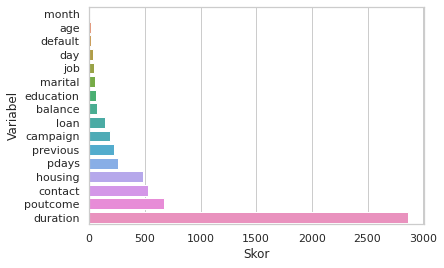

In [0]:
g=pd.DataFrame([])
g['Variabel']=list(X)
g['Skor']=scores.astype(int)
sns.set(style="whitegrid")
g=g.sort_values('Skor')
gx = sns.barplot(x="Skor", y="Variabel", data=g)
plt.show()

# **Classify Features Data**
Using **TensorFlow Feature Columns** as a bridge to map from columns in a CSV to features used to train the model

In [0]:
data = bank.copy()
dict_of_feature_column = {}
data = data.drop(['month','age'],axis=1)

for i in data.columns:

  # for Categorical Features
  if data[i].unique().dtype == np.object:

    # Change feature which only contain 'yes' & no -> 1 & 0
    if ('yes' and 'no' in data[i].unique()) and (len(data[i].unique()) == 2):
      data[i] = data[i].replace('yes', 1)
      data[i] = data[i].replace('no', 0)
      dict_of_feature_column[i] = feature_column.numeric_column(i)
    # Others
    else:
      temp = feature_column.categorical_column_with_vocabulary_list(i, data[i].unique())
      dict_of_feature_column[i] = feature_column.indicator_column(temp)
  
  # Special Features (Bucketized Features)
  # elif i == 'pdays':
  #   dict_of_feature_column[i] = feature_column.bucketized_column(feature_column.numeric_column(i), boundaries=[0])
  # elif i == 'duration':
  #   dict_of_feature_column[i] = feature_column.bucketized_column(feature_column.numeric_column(i), boundaries=[1000,2000,3000])

  # for Numeric Features
  else:
    dict_of_feature_column[i] = feature_column.numeric_column(i)

# print(bank)

#**Split the Data into Train and Test**
70% for the Model Training and 30% for the Model Testing

In [0]:
batch_size = 64
data = data.reindex(sorted(data.columns), axis=1)
x = data.copy()
y = x.pop('deposit')
x_train, x_test, y_train, y_test = train_test_split(
    x,y,test_size=0.3)
# x_test, x_val, y_test, y_val = train_test_split(
#     x_test,y_test,test_size=0.2)
# train, test = train_test_split(bank, test_size=0.25)
# test, val = train_test_split(test, test_size=0.25)
print("Train: ", len(x_train))
print("Test : ", len(x_test))
# print("Val  : ", len(x_val))
train_ds = tf.data.Dataset.from_tensor_slices((dict(x_train), y_train))
train_ds = train_ds.batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((dict(x_test), y_test))
test_ds = test_ds.batch(batch_size)
# val_ds = tf.data.Dataset.from_tensor_slices((dict(x_val), y_val))
# val_ds = val_ds.batch(batch_size)

Train:  7813
Test :  3349


In [0]:
# Delete the Target from Features
del dict_of_feature_column['deposit']

#**Deep Learning**
First we use **Neural Network** model with **Keras Layer**

##Input Layer
First layer is input layer of all features

In [0]:
feature_layer = tf.keras.layers.DenseFeatures([v for v in dict_of_feature_column.values()])

##Hidden Layer & Output Layer
For hidden layer, we use x dense layer (fully connected) with ReLU activation function.<br>
Last layer is output layer with 1 neuron.

In [0]:
nn_model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(30, activation='relu'),
  layers.Dense(10, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])

##Compile, Training, and Testing Model

In [0]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [0]:
nn_model.compile(optimizer='adam', 
                 loss='binary_crossentropy',
                 metrics=['acc',f1_m,precision_m, recall_m])

history = nn_model.fit(train_ds, 
                       #validation_data=val_ds,
                       epochs=20)

#loss, accuracy = nn_model.evaluate(test_ds)
#print("Accuracy", accuracy)
loss, accuracy, f1_score, precision, recall = nn_model.evaluate(test_ds)
print('Loss\t\t: ', loss)
print('Accuracy\t: ', accuracy)
print('F1 Score\t: ', f1_score)
print('Precision\t: ', precision)
print('Recall\t\t: ', recall)

Epoch 1/20
123/123 [==============================] - 0s 3ms/step - loss: 0.9235 - acc: 0.7488 - f1_m: 0.7225 - precision_m: 0.7566 - recall_m: 0.7217
Epoch 2/20
123/123 [==============================] - 0s 2ms/step - loss: 0.8077 - acc: 0.7560 - f1_m: 0.7318 - precision_m: 0.7569 - recall_m: 0.7385
Epoch 3/20
123/123 [==============================] - 0s 2ms/step - loss: 0.7561 - acc: 0.7610 - f1_m: 0.7350 - precision_m: 0.7643 - recall_m: 0.7345
Epoch 4/20
123/123 [==============================] - 0s 2ms/step - loss: 0.7794 - acc: 0.7598 - f1_m: 0.7323 - precision_m: 0.7669 - recall_m: 0.7274
Epoch 5/20
123/123 [==============================] - 0s 2ms/step - loss: 0.8232 - acc: 0.7537 - f1_m: 0.7304 - precision_m: 0.7592 - recall_m: 0.7354
Epoch 6/20
123/123 [==============================] - 0s 2ms/step - loss: 0.7443 - acc: 0.7635 - f1_m: 0.7404 - precision_m: 0.7656 - recall_m: 0.7410
Epoch 7/20
123/123 [==============================] - 0s 2ms/step - loss: 0.7518 - acc: 0.7604

In [0]:
print(history.history.keys())

y_pred = nn_model.predict_classes(test_ds, verbose=1)
print(y_pred.argmax(axis=1), type(y_pred.argmax(axis=1)), len(y_pred.argmax(axis=1)))

print(y_test.to_numpy(), type(y_test.to_numpy()), len(y_test.to_numpy()))

matrix = confusion_matrix(y_test, y_pred.argmax(axis=1))
print(matrix)

dict_keys(['loss', 'acc', 'f1_m', 'precision_m', 'recall_m'])
53/53 [==============================] - 0s 2ms/step
[0 0 0 ... 0 0 0] <class 'numpy.ndarray'> 3349
[1 1 1 ... 1 0 1] <class 'numpy.ndarray'> 3349
[[1744    0]
 [1605    0]]


#**Linear Classification**
Next, we compare with **Linear Classification** model with **TensorFlow Estimator**

## Create Input Function

In [0]:
def input_func(x,num_epochs):
  return tf.compat.v1.estimator.inputs.pandas_input_fn(
    x=x_train,
    y=y_train,
    batch_size=32,
    num_epochs=num_epochs,
    shuffle=True)

## Training Model

In [0]:
model = tf.compat.v1.estimator.LinearClassifier(feature_columns=[v for v in dict_of_feature_column.values()])
model.train(input_fn=input_func(x_train,num_epochs=20))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpdrjak0pu', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.


## Testing Model

In [0]:
pred_fn = tf.compat.v1.estimator.inputs.pandas_input_fn(
    x=x_test,batch_size=len(x_test),shuffle=False)
predictions = list(model.predict(input_fn=pred_fn))
final_preds = []
for pred in predictions:
    final_preds.append(pred['class_ids'][0])
eval_input_func = tf.compat.v1.estimator.inputs.pandas_input_fn(
    x=x_test,y=y_test,batch_size=len(x_test),shuffle=False)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpdrjak0pu/model.ckpt-4884
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


#**Results and Comparison**

##Deep Learning Training Graph

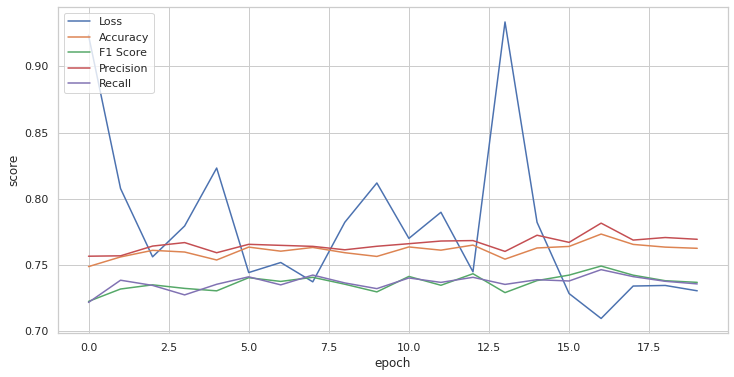

In [0]:
plt.figure(figsize =(12,6))
plt.plot(history.history['loss'])
plt.plot(history.history['acc'])
plt.plot(history.history['f1_m'])
plt.plot(history.history['precision_m'])
plt.plot(history.history['recall_m'])
plt.ylabel('score')
plt.xlabel('epoch')
plt.legend(['Loss', 'Accuracy', 'F1 Score', 'Precision', 'Recall'], loc='upper left')
plt.show()

## Deep Learning Test Score

In [0]:
print('--Test Score--')
print('Loss\t\t: ', loss)
print('Accuracy\t: ', accuracy)
print('F1 Score\t: ', f1_score)
print('Precision\t: ', precision)
print('Recall\t\t: ', recall)

--Test Score--
Loss		:  0.6619620323181152
Accuracy	:  0.8023290634155273
F1 Score	:  0.8057201504707336
Precision	:  0.7492789030075073
Recall		:  0.8775470852851868


##Linear Classification Confusion Matrix

In [0]:
cm = confusion_matrix(y_test,final_preds)

Text(66.5, 0.5, 'Actual Values')

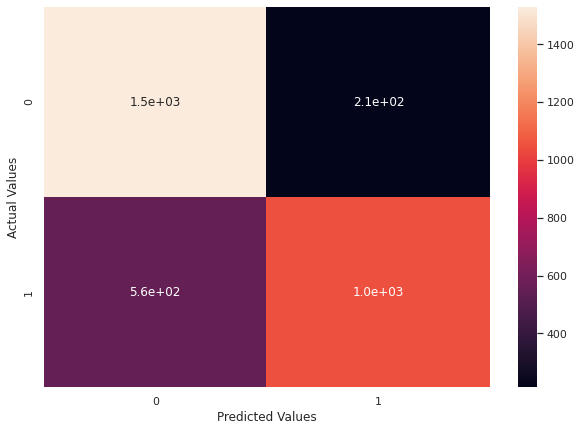

In [0]:
plt.figure(figsize =(10,7))
sns.heatmap(cm,annot=True)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

## Linear Classification Test Score

In [0]:
print(classification_report(y_test,final_preds))

              precision    recall  f1-score   support

           0       0.73      0.88      0.80      1743
           1       0.83      0.65      0.73      1606

    accuracy                           0.77      3349
   macro avg       0.78      0.77      0.77      3349
weighted avg       0.78      0.77      0.77      3349



In [0]:
results = model.evaluate(eval_input_func)
results

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-03-29T16:35:08Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpdrjak0pu/model.ckpt-4884
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.81422s
INFO:tensorflow:Finished evaluation at 2020-03-29-16:35:09
INFO:tensorflow:Saving dict for global step 4884: accuracy = 0.7700806, accuracy_baseline = 0.5204539, auc = 0.85157573, auc_precision_recall = 0.83275443, average_loss = 0.72353697, global_step = 4884, label/mean = 0.47954613, loss = 2423.1252, precision = 0.8306962, prediction/mean = 0.39164382, recall = 0.6537983
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 4884: /tmp/tmpdrjak0pu/model.ckpt-4884


{'accuracy': 0.7700806,
 'accuracy_baseline': 0.5204539,
 'auc': 0.85157573,
 'auc_precision_recall': 0.83275443,
 'average_loss': 0.72353697,
 'global_step': 4884,
 'label/mean': 0.47954613,
 'loss': 2423.1252,
 'precision': 0.8306962,
 'prediction/mean': 0.39164382,
 'recall': 0.6537983}

In [0]:
print("F1 Score: {}".format(f1_score(y_test,final_preds)))

F1 Score: 0.7317073170731707
